# **Load Modules**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp /content/drive/MyDrive/NLP/Data/abbreviations.py .

In [3]:
import pandas as pd 
import numpy as np
import re
from abbreviations import abbreviation
from collections import Counter
import json

In [4]:
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/DataLoader.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/Dataset.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/Dict.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/Tweet.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/constants.py .

!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/loss.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/metrics.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/utils.py .

!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/model.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/model_factory.py .

!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/evaluator.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/optim.py .
!cp /content/drive/MyDrive/NLP/TextNormSeq2Seq/lib/trainer.py .

In [5]:
import torch
from torch.backends import cudnn
from torch import cuda
import numpy as np
import argparse
import random
import os
import logging
import copy
import easydict
from statistics import mean

In [6]:
from Tweet import Tweet
from DataLoader import create_data, create_datasets
from model_factory import create_model
from evaluator import Evaluator
from trainer import Trainer
import constants

# **Preprocessing**

In [7]:
path = "/content/drive/MyDrive/NLP/Data/"
topics = ['Chính Trị', 'Hóa Học', 'Lịch Sử', 'Nghệ Thuật', 'Ngữ Văn', 'Sinh Học', 'Tin Học', 'Toán Học', 'Vật Lý', 'Địa Lí']

In [8]:
short_texts = [] # short
full_texts = [] # full
for topic in topics:
  fullfile = path + topic + '/Full Text.txt'
  shortfile = path + topic + '/Short Text.txt'
  fulltext = pd.read_csv(fullfile, sep='\n', header=None, index_col=None, encoding = 'UTF-8')
  shorttext = pd.read_csv(shortfile, sep='\n', header=None, index_col=None, encoding = 'UTF-8')

  short_texts.append(shorttext[0].values.tolist())
  full_texts.append(fulltext[0].values.tolist())

In [9]:
short_texts = [sent for topic in short_texts for sent in topic]
full_texts = [sent for topic in full_texts for sent in topic]
print('Number of Short Sentences', len(short_texts))
print('Number of Full Sentences', len(full_texts))

Number of Short Sentences 1000
Number of Full Sentences 1000


In [10]:
tone_dict_map = {
    "òa": "oà",
    "Òa": "Oà",
    "ÒA": "OÀ",
    "óa": "oá",
    "Óa": "Oá",
    "ÓA": "OÁ",
    "ỏa": "oả",
    "Ỏa": "Oả",
    "ỎA": "OẢ",
    "õa": "oã",
    "Õa": "Oã",
    "ÕA": "OÃ",
    "ọa": "oạ",
    "Ọa": "Oạ",
    "ỌA": "OẠ",
    "òe": "oè",
    "Òe": "Oè",
    "ÒE": "OÈ",
    "óe": "oé",
    "Óe": "Oé",
    "ÓE": "OÉ",
    "ỏe": "oẻ",
    "Ỏe": "Oẻ",
    "ỎE": "OẺ",
    "õe": "oẽ",
    "Õe": "Oẽ",
    "ÕE": "OẼ",
    "ọe": "oẹ",
    "Ọe": "Oẹ",
    "ỌE": "OẸ",
    "ùy": "uỳ",
    "Ùy": "Uỳ",
    "ÙY": "UỲ",
    "úy": "uý",
    "Úy": "Uý",
    "ÚY": "UÝ",
    "ủy": "uỷ",
    "Ủy": "Uỷ",
    "ỦY": "UỶ",
    "ũy": "uỹ",
    "Ũy": "Uỹ",
    "ŨY": "UỸ",
    "ụy": "uỵ",
    "Ụy": "Uỵ",
    "ỤY": "UỴ",
    }

def tone_normalize(text, tone_dict_map):
    for i, j in tone_dict_map.items():
        text = text.replace(i, j)
    return text

In [11]:
def tokenize(text):
  s = tone_normalize(text, tone_dict_map)
  #s = text
  s = re.sub('([.,!?()“”;"\':…])', r' \1 ', s)
  s = re.sub('\s{2,}', ' ', s)
  s = s.lower().strip()
  return s

In [12]:
def add_white_space(text, index):
  if(index == 0): return (text + ' ')
  elif(index == -1): return (' ' + text)
  else: return (' ' + text + ' ')

In [13]:
full_texts_tokenized = full_texts.copy()
for i in range(len(full_texts_tokenized)):
  full_texts_tokenized[i] = tokenize(full_texts_tokenized[i])

In [14]:
input_texts = []
target_texts = []

for i in range(len(short_texts)): # each of short sentences
  #print(i + 1)
  input = tokenize(short_texts[i]).split() # list of tokens in a short sentence
  input_texts.append(input)
  target = []
  for j in range(len(input)): # each of tokens in a short sentence
    if(j == len(input) - 1): index = -1
    else: index = j
    token = add_white_space(input[j], index)
    if(full_texts_tokenized[i].find(token) != -1): # if token found in full sentence
      if (token == ' an ' and full_texts_tokenized[i].find(' ninh ') != -1):
        target.append('an ninh')
      else: target.append(input[j])
    else: # if token not found in full sentence then it's an abbreviation
      expansion_list = abbreviation[input[j]]
      if(len(expansion_list) == 1): # check in abbreviation dict if this abb has 1 expansion
        target.append(expansion_list[0])
      else: # there are more than 1 expansion
        for full in expansion_list: # iterate through each expansion
          if j == 0:
            if(full_texts_tokenized[i][:len(full)] == full):
              target.append(full)
              break
          else:
            token = target[-1] + add_white_space(full, index)
            if(full_texts_tokenized[i].find(token) != -1): # if expansion found in full sentence
              target.append(full)
              break
  target_texts.append(target)

In [15]:
print(len(input_texts))
print(len(target_texts))

1000
1000


In [16]:
def count_vocab(data):
  vocab = []
  for sent in data:
    sent = sent['output']
    for token in sent:
      if re.search('([.,!?()“”;"\':…])', token) is None:
        vocab.append(token)

  return len(vocab)

In [17]:
def abbr(data):
  ABBs = []
  for i in range(len(data)):
    short = data[i]['input']
    full = data[i]['output']
    for i in range(len(short)):
      if (short[i] != full[i]):
        ABBs.append(short[i])

  return ABBs

In [18]:
max_len = []
for sent in input_texts:
  max_len.append(len(sent))

max(max_len)

73

In [19]:
data = []
for i in range(1000):
  sentence = {}
  sentence['id'] = i + 1
  sentence['input'] = input_texts[i]
  sentence['output'] = target_texts[i]
  data.append(sentence)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_data, test_data = train_test_split(data, test_size = 0.1, random_state = 42)

In [22]:
print(len(train_data))
print(len(test_data))

900
100


In [23]:
print(count_vocab(train_data))
print(count_vocab(test_data))

18480
2275


In [24]:
train_abbr = abbr(train_data)
test_abbr = abbr(test_data)

print(len(train_abbr))
print(len(test_abbr))

3676
469


In [25]:
print(len(list(set(train_abbr))))
print(len(list(set(test_abbr))))

683
199


In [26]:
Counter(train_abbr)

Counter({'mđ': 6,
         'k/định': 3,
         'pt': 32,
         'pứ': 1,
         'nt': 12,
         'qt': 14,
         'hthanh': 7,
         'nđ': 8,
         'sd': 21,
         '1': 95,
         'dl': 32,
         'yc': 3,
         'nh': 14,
         '#': 17,
         'tíh': 12,
         'ứg': 5,
         'đv': 27,
         'trl': 2,
         'mtrg': 7,
         'trog': 29,
         '/': 11,
         'cthể': 7,
         'vs': 62,
         'sốg': 17,
         'ng': 71,
         'lđ': 7,
         'xk': 2,
         'cn': 26,
         'ñ': 83,
         'hchc': 5,
         'trg': 156,
         'tb': 29,
         'ko': 52,
         'nc': 94,
         'kv': 10,
         'qs': 6,
         'đná': 4,
         'dih': 3,
         'dưỡg': 7,
         'thườg': 3,
         'đc': 118,
         'sug': 1,
         'đồg': 7,
         'ngừg': 3,
         'trìh': 8,
         'hquả': 3,
         'sih': 26,
         'khg': 1,
         'nlhp': 1,
         'cc': 2,
         'lg': 18,
         'cđ': 23,
 

In [27]:
Counter(train_abbr).most_common(10)

[('trg', 156),
 ('đc', 118),
 ('1', 95),
 ('nc', 94),
 ('ñ', 83),
 ('ng', 71),
 ('vs', 62),
 ('ko', 52),
 ('kt', 52),
 ('n', 42)]

In [28]:
Counter(test_abbr).most_common(10)

[('đc', 21),
 ('nc', 20),
 ('1', 15),
 ('ct', 11),
 ('trg', 10),
 ('ñ', 10),
 ('kt', 9),
 ('cm', 8),
 ('vs', 8),
 ('n', 8)]

In [29]:
#with open("/content/drive/MyDrive/NLP/Data/train_data.json", "w") as outfile:
    #json.dump(train_data, outfile, ensure_ascii=False)

#with open("/content/drive/MyDrive/NLP/Data/test_data.json", "w") as outfile:
    #json.dump(test_data, outfile, ensure_ascii=False)

# **Train Model**

In [ ]:
def change_args(opt):
    torch.backends.cudnn.enabled = False
    cudnn.benchmark = False
    cudnn.deterministic = True
    torch.backends.cudnn.deterministic = True
    random.seed(opt.seed)
    torch.manual_seed(opt.seed)
    torch.cuda.manual_seed(opt.seed)
    torch.cuda.manual_seed_all(opt.seed)
    np.random.seed(opt.seed)
    if opt.save_dir and not os.path.exists(opt.save_dir): os.makedirs(opt.save_dir)
    logging.basicConfig(filename=os.path.join(opt.save_dir, 'output.log') if opt.logfolder else None, level=logging.INFO)
    if opt.self_tok: opt.self_tok=constants.SELF
    opt.cuda = (opt.gpu != -1) # Set cuda
    if torch.cuda.is_available() and not opt.cuda:
        logger.warning("WARNING: You have a CUDA device, so you should probably run with -gpu 1")
    if opt.cuda: cuda.set_device(opt.gpu)
    if opt.share_embeddings:
        if not opt.share_vocab:
            logger.warning('src/tgt vocab should be the same if you use share_embeddings! Changing share_vocab to True.')
            opt.share_vocab = True
    return opt

In [ ]:
logger = logging.getLogger("main")

def train_char_model(args):
    logger.info('*** Character model ***')
    opt = copy.deepcopy(args)
    opt.input = 'spelling'
    train_data, valid_data, test_data, vocab, mappings = create_datasets(opt)
    char_model, char_optim = create_model((vocab['src'], vocab['tgt']), opt, is_char_model = True)
    char_evaluator = Evaluator(char_model, opt)
    char_test_evaluator = Evaluator(char_model, opt)
    logger.info(char_model.opt)
    logger.info('Loading test data for character model from "%s"' % opt.testdata)
    logger.info('Loading training data for character model from "%s"' % opt.traindata)
    logger.info(' * Character model vocabulary size. source = %d; target = %d' % (len(vocab['src']), len(vocab['tgt'])))
    logger.info(' * Character model maximum batch size. %d' % opt.batch_size)
    logger.info(char_model)
    if opt.interactive and args.input != 'hybrid':
        while True:
            var = input("Please enter a word to be try spelling model (q to quit): ")
            if var.lower() == 'q': break
            tweets = [Tweet(var.split(), var.split(), '1', '1') for i in range(2)]  # suboptimal but works with minimal changes
            test_data, test_vocab, mappings = create_data(tweets, opt=opt, vocab=vocab, mappings=mappings)
            prediction = char_test_evaluator.eval(test_data)
            print('Prediction is: {}'.format(''.join(prediction)))
    elif opt.eval: # Evaluation only
        logger.info("=======Char eval on test set=============")
        pred_file = os.path.join(opt.save_dir, 'test.pred.char')
        char_test_evaluator.eval(test_data, pred_file=pred_file)
        logger.info("=======Char eval on validation set=============")
        pred_file = os.path.join(opt.save_dir, 'valid.pred.char')
        char_evaluator.eval(valid_data, pred_file=pred_file)
    else: # Training
        char_trainer = Trainer(char_model, char_evaluator, train_data, valid_data ,char_optim, opt)
        char_trainer.train(opt.start_epoch, opt.end_epoch)
        logger.info("=======Eval on test set=============")
        pred_file = os.path.join(opt.save_dir, 'test.pred.char')
        char_test_evaluator.eval(test_data, pred_file=pred_file)
        logger.info("=======Eval on validation set=============")
        pred_file = os.path.join(opt.save_dir, 'valid.pred.char')
        char_evaluator.eval(valid_data, pred_file=pred_file)
        logger.info('*** Finished Character model ***\n')
    return char_model

In [ ]:
def main(args):
    opt = args
    opt = change_args(opt)
    logging.basicConfig(filename=os.path.join(opt.save_dir, 'output.log') if opt.logfolder else None, level=logging.INFO)
    unk_model = train_char_model(opt) if(opt.input in ['hybrid', 'spelling']) else None
    if(opt.input =='spelling'): exit()
    train_data, valid_data, test_data, vocab, mappings = create_datasets(opt)
    model, optim = create_model((vocab['src'], vocab['tgt']), opt)
    evaluator = Evaluator(model, opt, unk_model)
    test_evaluator = Evaluator(model, opt, unk_model)
    logger.info(model.opt)
    logger.info('Loading test data from "%s"' % opt.testdata)
    logger.info('Loading training data from "%s"' % opt.traindata)
    logger.info(' * Vocabulary size. source = %d; target = %d' % (len(vocab['src']), len(vocab['tgt'])))
    logger.info(' * Maximum batch size. %d' % opt.batch_size)
    logger.info(model)
    if opt.interactive:
        while True:
            var = input("Please enter the text to be normalized (q to quit): ")
            if var.lower() == 'q': break
            tweets = [Tweet(var.split(), var.split(), '1', '1') for i in range(2)] #suboptimal but works with minimal changes
            test_data, test_vocab, mappings = create_data(tweets, opt=opt, vocab=vocab,mappings=mappings)
            prediction = test_evaluator.eval(test_data)
            print('Prediction is: {}'.format(' '.join(prediction)))
    elif opt.eval: # Evaluation only
        logger.info("=======Eval on test set=============")
        pred_file = os.path.join(opt.save_dir, 'test.pred')
        test_evaluator.eval(test_data, pred_file=pred_file)
        logger.info("=======Eval on validation set=============")
        pred_file = os.path.join(opt.save_dir, 'valid.pred')
        evaluator.eval(valid_data, pred_file=pred_file)
    else: # Training
        trainer = Trainer(model, evaluator, train_data, valid_data ,optim, opt)
        trainer.train(opt.start_epoch, opt.end_epoch)
        logger.info("=======Eval on test set=============")
        pred_file = os.path.join(opt.save_dir, 'test.pred')
        test_evaluator.eval(test_data, pred_file=pred_file)
        logger.info("=======Eval on validation set=============")
        pred_file = os.path.join(opt.save_dir, 'valid.pred')
        evaluator.eval(valid_data, pred_file=pred_file)

## Word Model

In [ ]:
word_args = easydict.EasyDict({
    'traindata': '/content/drive/MyDrive/NLP/Data/train_data.json',
    'testdata': '/content/drive/MyDrive/NLP/Data/test_data.json',
    'valsplit': 0,
    'vocab_size': None,
    'lowercase': False,
    'share_vocab': True,
    'eos': True,
    'bos': True,
    'self_tok': False,
    'input': 'word',
    'maxlen': None,
    'correct_unique_mappings': False,
    'char_model': 'None',
    'data_augm': False,
    'rnn_type': 'LSTM',
    'layers': 3,
    'brnn': True,
    'rnn_size': 200,
    'emb_size': 100,
    'attention': True,
    'bias': True,
    'tie_decoder_embeddings': True,
    'share_embeddings': True,
    'dropout': 0.5,
    'backward_split': None,
    'teacher_forcing_ratio': 0.6,
    'noise_ratio': 0,
    'batch_size': 32,
    'start_epoch': 1,
    'end_epoch': 50,
    'optim': 'adam',
    'lr': 0.01,
    'max_grad_norm': 5,
    'learning_rate_decay': 0.05,
    'start_decay_after': 15,
    'gpu': -1,
    'log_interval': 1,
    'save_interval': -1,
    'seed': 3435,
    'logfolder': True,
    'save_dir': '/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2S',
    'load_from': None,
    'eval': False,
    'interactive': False,
    'max_train_decode_len': 100
})

In [ ]:
if __name__ == "__main__":
    main(word_args)

## S2SSelf

In [ ]:
self_args = easydict.EasyDict({
    'traindata': '/content/drive/MyDrive/NLP/Data/train_data.json',
    'testdata': '/content/drive/MyDrive/NLP/Data/test_data.json',
    'valsplit': 0,
    'vocab_size': None,
    'lowercase': False,
    'share_vocab': True,
    'eos': True,
    'bos': True,
    'self_tok': True,
    'input': 'word',
    'maxlen': None,
    'correct_unique_mappings': False,
    'char_model': None,
    'data_augm': False,
    'rnn_type': 'LSTM',
    'layers': 3,
    'brnn': True,
    'rnn_size': 100,
    'emb_size': 100,
    'attention': True,
    'bias': True,
    'tie_decoder_embeddings': True,
    'share_embeddings': True,
    'dropout': 0.2,
    'backward_split': None,
    'teacher_forcing_ratio': 0.6,
    'noise_ratio': 0,
    'batch_size': 32,
    'start_epoch': 1,
    'end_epoch': 50,
    'optim': 'adam',
    'lr': 0.01,
    'max_grad_norm': 10,
    'learning_rate_decay': 0.05,
    'start_decay_after': 15,
    'gpu': -1,
    'log_interval': 1,
    'save_interval': -1,
    'seed': 3435,
    'logfolder': True,
    'save_dir': '/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SSelf',
    'load_from': None,
    'eval': False,
    'interactive': False,
    'max_train_decode_len': 100
})

In [ ]:
if __name__ == "__main__":
    main(self_args)

## S2SMulti

In [ ]:
multi_args = easydict.EasyDict({
    'traindata': '/content/drive/MyDrive/NLP/Data/train_data.json',
    'testdata': '/content/drive/MyDrive/NLP/Data/test_data.json',
    'valsplit': 0,
    'vocab_size': None,
    'lowercase': False,
    'share_vocab': True,
    'eos': True,
    'bos': True,
    'self_tok': False,
    'input': 'word',
    'maxlen': None,
    'correct_unique_mappings': True,
    'char_model': None,
    'data_augm': False,
    'rnn_type': 'LSTM',
    'layers': 3,
    'brnn': True,
    'rnn_size': 200,
    'emb_size': 100,
    'attention': True,
    'bias': True,
    'tie_decoder_embeddings': True,
    'share_embeddings': True,
    'dropout': 0.5,
    'backward_split': None,
    'teacher_forcing_ratio': 0.6,
    'noise_ratio': 0,
    'batch_size': 32,
    'start_epoch': 1,
    'end_epoch': 50,
    'optim': 'adam',
    'lr': 0.01,
    'max_grad_norm': 5,
    'learning_rate_decay': 0.05,
    'start_decay_after': 15,
    'gpu': -1,
    'log_interval': 1,
    'save_interval': -1,
    'seed': 3435,
    'logfolder': True,
    'save_dir': '/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SMulti',
    'load_from': None,
    'eval': False,
    'interactive': False,
    'max_train_decode_len': 100
})

In [ ]:
if __name__ == "__main__":
    main(multi_args)

# **Evaluate**

## Word Model

In [30]:
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2S/test.pred', 'r') as json_data:
    test_res = json.load(json_data)
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2S/valid.pred', 'r') as json_data:
    train_res = json.load(json_data)

In [31]:
test_input = []
test_target = []
test_output = []
test_score = []
for sent in test_res:
  test_input.append(sent['input'])
  test_target.append(sent['target'])
  test_output.append(sent['output'])
  test_score.append(sent['score'])

In [32]:
train_input = []
train_target = []
train_output = []
train_score = []
for sent in train_res:
  train_input.append(sent['input'])
  train_target.append(sent['target'])
  train_output.append(sent['output'])
  train_score.append(sent['score'])

In [33]:
print(mean(test_score))
print(mean(train_score))

0.6978284606357611
0.8822229608434619


## S2SSelf

In [34]:
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SSelf/test.pred', 'r') as json_data:
    test_res = json.load(json_data)
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SSelf/valid.pred', 'r') as json_data:
    train_res = json.load(json_data)

In [35]:
test_input = []
test_target = []
test_output = []
test_score = []
for sent in test_res:
  test_input.append(sent['input'])
  test_target.append(sent['target'])
  test_output.append(sent['output'])
  test_score.append(sent['score'])

In [36]:
train_input = []
train_target = []
train_output = []
train_score = []
for sent in train_res:
  train_input.append(sent['input'])
  train_target.append(sent['target'])
  train_output.append(sent['output'])
  train_score.append(sent['score'])

In [37]:
print(mean(test_score))
print(mean(train_score))

0.4937465385491701
0.774232672444141


## S2SMulti

In [38]:
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SMulti/test.pred', 'r') as json_data:
    test_res = json.load(json_data)
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SMulti/valid.pred', 'r') as json_data:
    train_res = json.load(json_data)

In [39]:
test_input = []
test_target = []
test_output = []
test_score = []
for sent in test_res:
  test_input.append(sent['input'])
  test_target.append(sent['target'])
  test_output.append(sent['output'])
  test_score.append(sent['score'])

In [40]:
train_input = []
train_target = []
train_output = []
train_score = []
for sent in train_res:
  train_input.append(sent['input'])
  train_target.append(sent['target'])
  train_output.append(sent['output'])
  train_score.append(sent['score'])

In [41]:
print(mean(test_score))
print(mean(train_score))

0.8070394710653331
0.9522115291141607


# **Error Analysis**

In [42]:
train_abbr_freq = Counter(train_abbr)
train_abbr_freq.get('đst')

2

In [43]:
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2S/test.pred', 'r') as json_data:
    word_res = json.load(json_data)
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SSelf/test.pred', 'r') as json_data:
    self_res = json.load(json_data)
with open('/content/drive/MyDrive/NLP/TextNormSeq2Seq/S2SMulti/test.pred', 'r') as json_data:
    multi_res = json.load(json_data)

In [44]:
i = 33
print(word_res[i]['input'])
print(word_res[i]['target'])
print(word_res[i]['output'])
print(self_res[i]['output'])
print(multi_res[i]['output'])

['mb', 'đã', 'được', 'gp', 'nên', 'phải', 'nhanh', 'chóng', 'tiến', 'hành', 'khôi', 'phục', 'kt', ',', 'hàn', 'gắn', 'vết', 'thương', 'ct', ';', 'đưa', 'mb', 'tiến', 'lên', 'cnxh', ',', 'làm', 'cho', 'miền', 'bắc', 'vững', 'mạnh', ',', 'trở', 'thành', 'hậu', 'phương', 'vững', 'chắc', 'cho', 'cuộc', 'kc', 'chống', 'mĩ', ',', 'cứu', 'nc', '.']
['miền bắc', 'đã', 'được', 'giải phóng', 'nên', 'phải', 'nhanh', 'chóng', 'tiến', 'hành', 'khôi', 'phục', 'kinh tế', ',', 'hàn', 'gắn', 'vết', 'thương', 'chiến tranh', ';', 'đưa', 'miền bắc', 'tiến', 'lên', 'chủ nghĩa xã hội', ',', 'làm', 'cho', 'miền', 'bắc', 'vững', 'mạnh', ',', 'trở', 'thành', 'hậu', 'phương', 'vững', 'chắc', 'cho', 'cuộc', 'kháng chiến', 'chống', 'mĩ', ',', 'cứu', 'nước', '.']
['mb', 'đã', 'được', 'gp', 'nên', 'phải', 'nhanh', 'chóng', 'tiến', 'hành', 'khôi', 'phục', 'kinh tế', ',', 'hàn', 'gắn', 'vết', 'thương', 'chiến tranh', ';', 'đưa', 'mb', 'tiến', 'lên', 'cnxh', ',', 'làm', 'cho', 'miền', '.', '', '', '', '', '', '', '', 

In [45]:
sentence_id = []
token_id = []
input = []
is_abbr = []
train_freq = []
target = []
S2S_output = []
S2SSelf_output = []
S2SMulti_output = []

for i in range(len(word_res)):
  input_sent = word_res[i]['input']
  target_sent = word_res[i]['target']
  word_output = word_res[i]['output']
  self_output = self_res[i]['output']
  multi_output = multi_res[i]['output']
  for j in range(len(input_sent)):
    sentence_id.append(i)
    token_id.append(j)
    input.append(input_sent[j])
    target.append(target_sent[j])
    S2S_output.append(word_output[j])
    S2SSelf_output.append(self_output[j])
    S2SMulti_output.append(multi_output[j])
    if(input_sent[j] != target_sent[j]):
      is_abbr.append('Yes')
      train_freq.append(train_abbr_freq.get(input_sent[j]))
    else:
      is_abbr.append('No')
      train_freq.append(0)
res = pd.DataFrame(list(zip(sentence_id, token_id, input, is_abbr, train_freq, target, S2S_output, S2SSelf_output, S2SMulti_output)), 
             columns =['sentence_id', 'token_id', 'input', 'is_abbr', 'train_freq', 'target', 'S2S_output', 'S2SSelf_output', 'S2SMulti_output'])
res

,sentence_id,token_id,input,is_abbr,train_freq,target,S2S_output,S2SSelf_output,S2SMulti_output
0,0,0,nếu,No,0.0,nếu,nếu,nếu,nếu
1,0,1,một,No,0.0,một,một,một,một
2,0,2,vật,No,0.0,vật,vật,vật,vật
3,0,3,k,Yes,8.0,không,không,k,k
4,0,4,chịu,No,0.0,chịu,chịu,chịu,chịu
...,...,...,...,...,...,...,...,...,...
2516,99,19,tự,No,0.0,tự,tự,tự,tự
2517,99,20,an,Yes,9.0,an ninh,an ninh,an,an ninh
2518,99,21,toàn,No,0.0,toàn,toàn,xã hội,toàn
2519,99,22,xh,Yes,29.0,xã hội,xã hội,xh,xã hội


In [46]:
abbr_pred = res[res['is_abbr'] == 'Yes'].reset_index(drop = True)
is_true_pred_S2S = []
is_true_pred_S2SSelf = []
is_true_pred_S2SMulti = []
is_wrong_pred_S2S = []
is_wrong_pred_S2SSelf = []
is_wrong_pred_S2SMulti = []
count = []
for i in range(abbr_pred.shape[0]):
  count.append(1)
  target = abbr_pred['target'][i]
  if(abbr_pred['S2S_output'][i] == target):
    is_true_pred_S2S.append(1)
    is_wrong_pred_S2S.append(0)
  else: 
    is_true_pred_S2S.append(0)
    is_wrong_pred_S2S.append(1)
  if(abbr_pred['S2SSelf_output'][i] == target):
    is_true_pred_S2SSelf.append(1)
    is_wrong_pred_S2SSelf.append(0)
  else: 
    is_true_pred_S2SSelf.append(0)
    is_wrong_pred_S2SSelf.append(1)
  if(abbr_pred['S2SMulti_output'][i] == target):
    is_true_pred_S2SMulti.append(1)
    is_wrong_pred_S2SMulti.append(0)
  else: 
    is_true_pred_S2SMulti.append(0)
    is_wrong_pred_S2SMulti.append(1)

abbr_pred['is_true_pred_S2S'] = is_true_pred_S2S
abbr_pred['is_wrong_pred_S2S'] = is_wrong_pred_S2S
abbr_pred['is_true_pred_S2SSelf'] = is_true_pred_S2SSelf
abbr_pred['is_wrong_pred_S2SSelf'] = is_wrong_pred_S2SSelf
abbr_pred['is_true_pred_S2SMulti'] = is_true_pred_S2SMulti
abbr_pred['is_wrong_pred_S2SMulti'] = is_wrong_pred_S2SMulti
abbr_pred['count'] = count
abbr_pred

,sentence_id,token_id,input,is_abbr,train_freq,target,S2S_output,S2SSelf_output,S2SMulti_output,is_true_pred_S2S,is_wrong_pred_S2S,is_true_pred_S2SSelf,is_wrong_pred_S2SSelf,is_true_pred_S2SMulti,is_wrong_pred_S2SMulti,count
0,0,3,k,Yes,8.0,không,không,k,k,1,0,0,1,0,1,1
1,0,5,t/dụng,Yes,7.0,tác dụng,tác dụng,tác dụng,tác dụng,1,0,1,0,1,0,1
2,0,11,tdụng,Yes,3.0,tác dụng,tác dụng,tác dụng,tác dụng,1,0,1,0,1,0,1
3,0,19,0,Yes,16.0,không,không,0,không,1,0,0,1,1,0,1
4,0,33,cđ,Yes,23.0,chuyển động,đang,cđ,chuyển động,0,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,99,7,lg,Yes,18.0,lượng,lượng,lượng,lượng,1,0,1,0,1,0,1
465,99,10,bv,Yes,9.0,bảo vệ,bảo vệ,bảo vệ,bảo vệ,1,0,1,0,1,0,1
466,99,11,an,Yes,9.0,an ninh,an ninh,an,an ninh,1,0,0,1,1,0,1
467,99,20,an,Yes,9.0,an ninh,an ninh,an,an ninh,1,0,0,1,1,0,1


In [47]:
abbr_pred[abbr_pred['input'] == 'đb']

,sentence_id,token_id,input,is_abbr,train_freq,target,S2S_output,S2SSelf_output,S2SMulti_output,is_true_pred_S2S,is_wrong_pred_S2S,is_true_pred_S2SSelf,is_wrong_pred_S2SSelf,is_true_pred_S2SMulti,is_wrong_pred_S2SMulti,count
71,16,11,đb,Yes,9.0,đặc biệt,đặc biệt,đặc biệt,đặc biệt,1,0,1,0,1,0,1
205,45,7,đb,Yes,9.0,đặc biệt,đặc biệt,trong,đặc biệt,1,0,0,1,1,0,1


In [48]:
abbr_pred_count = abbr_pred.drop(['sentence_id', 'token_id', 'train_freq'], axis = 1).groupby('input').sum()
freq = []
for i in abbr_pred_count.index:
  freq.append(train_abbr_freq.get(i))
abbr_pred_count['train_freq'] = freq
abbr_pred_count

,is_true_pred_S2S,is_wrong_pred_S2S,is_true_pred_S2SSelf,is_wrong_pred_S2SSelf,is_true_pred_S2SMulti,is_wrong_pred_S2SMulti,count,train_freq
input,,,,,,,,
#,1,0,0,1,1,0,1,17.0
/,2,0,1,1,2,0,2,11.0
//,4,0,2,2,4,0,4,9.0
0,4,0,1,3,4,0,4,16.0
1,15,0,13,2,15,0,15,95.0
...,...,...,...,...,...,...,...,...
đt,4,2,3,3,4,2,6,26.0
đv,0,2,0,2,1,1,2,27.0
đá,0,1,0,1,0,1,1,1.0


In [49]:
abbr_pred_count.loc[['đc', 'nc', '1', 'trg', 'ñ']]

,is_true_pred_S2S,is_wrong_pred_S2S,is_true_pred_S2SSelf,is_wrong_pred_S2SSelf,is_true_pred_S2SMulti,is_wrong_pred_S2SMulti,count,train_freq
input,,,,,,,,
đc,20,1,12,9,21,0,21,118.0
nc,19,1,11,9,20,0,20,94.0
1,15,0,13,2,15,0,15,95.0
trg,10,0,8,2,10,0,10,156.0
ñ,10,0,7,3,10,0,10,83.0


In [50]:
abbr_pred_ratio = abbr_pred_count.assign()
count = abbr_pred_ratio['count']
cols = abbr_pred_ratio.columns[:-2]
for col in cols:
  abbr_pred_ratio[col] = abbr_pred_ratio[col]/count
abbr_pred_ratio['avg_true_ratio'] = (abbr_pred_ratio['is_true_pred_S2S'] + abbr_pred_ratio['is_true_pred_S2SSelf'] + abbr_pred_ratio['is_true_pred_S2SMulti'])/3
abbr_pred_ratio['avg_wrong_ratio'] = (abbr_pred_ratio['is_wrong_pred_S2S'] + abbr_pred_ratio['is_wrong_pred_S2SSelf'] + abbr_pred_ratio['is_wrong_pred_S2SMulti'])/3
abbr_pred_ratio

,is_true_pred_S2S,is_wrong_pred_S2S,is_true_pred_S2SSelf,is_wrong_pred_S2SSelf,is_true_pred_S2SMulti,is_wrong_pred_S2SMulti,count,train_freq,avg_true_ratio,avg_wrong_ratio
input,,,,,,,,,,
#,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1,17.0,0.666667,0.333333
/,1.000000,0.000000,0.500000,0.500000,1.000000,0.000000,2,11.0,0.833333,0.166667
//,1.000000,0.000000,0.500000,0.500000,1.000000,0.000000,4,9.0,0.833333,0.166667
0,1.000000,0.000000,0.250000,0.750000,1.000000,0.000000,4,16.0,0.750000,0.250000
1,1.000000,0.000000,0.866667,0.133333,1.000000,0.000000,15,95.0,0.955556,0.044444
...,...,...,...,...,...,...,...,...,...,...
đt,0.666667,0.333333,0.500000,0.500000,0.666667,0.333333,6,26.0,0.611111,0.388889
đv,0.000000,1.000000,0.000000,1.000000,0.500000,0.500000,2,27.0,0.166667,0.833333
đá,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1,1.0,0.000000,1.000000


In [51]:
abbr_pred_ratio[abbr_pred_ratio['is_true_pred_S2SMulti'] == 1].sort_values(by=['count'], ascending = False)

,is_true_pred_S2S,is_wrong_pred_S2S,is_true_pred_S2SSelf,is_wrong_pred_S2SSelf,is_true_pred_S2SMulti,is_wrong_pred_S2SMulti,count,train_freq,avg_true_ratio,avg_wrong_ratio
input,,,,,,,,,,
đc,0.952381,0.047619,0.571429,0.428571,1.0,0.0,21,118.0,0.841270,0.158730
nc,0.950000,0.050000,0.550000,0.450000,1.0,0.0,20,94.0,0.833333,0.166667
1,1.000000,0.000000,0.866667,0.133333,1.0,0.0,15,95.0,0.955556,0.044444
ñ,1.000000,0.000000,0.700000,0.300000,1.0,0.0,10,83.0,0.900000,0.100000
trg,1.000000,0.000000,0.800000,0.200000,1.0,0.0,10,156.0,0.933333,0.066667
...,...,...,...,...,...,...,...,...,...,...
k/năng,0.000000,1.000000,0.000000,1.000000,1.0,0.0,1,1.0,0.333333,0.666667
hìh,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1,11.0,1.000000,0.000000
hthanh,1.000000,0.000000,0.000000,1.000000,1.0,0.0,1,7.0,0.666667,0.333333


Text(0, 0.5, 'Khả năng dự đoán đúng trong tập test')

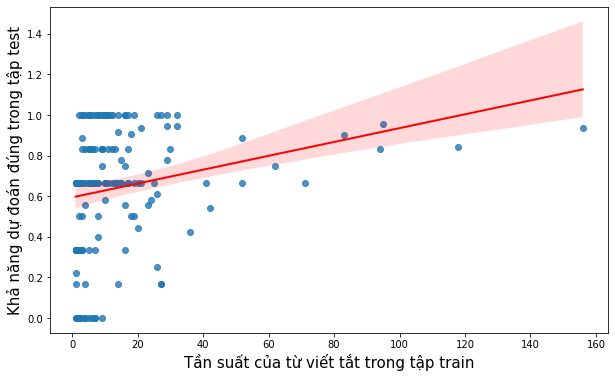

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
sns.regplot(x=abbr_pred_ratio['train_freq'], y=abbr_pred_ratio['avg_true_ratio'], line_kws={"color":"r","lw":2})
plt.xlabel('Tần suất của từ viết tắt trong tập train', fontsize = 15)
plt.ylabel('Khả năng dự đoán đúng trong tập test', fontsize = 15)

In [53]:
abbr_pred_ratio.sort_values(by=['avg_true_ratio'], ascending = False)[:50]

,is_true_pred_S2S,is_wrong_pred_S2S,is_true_pred_S2SSelf,is_wrong_pred_S2SSelf,is_true_pred_S2SMulti,is_wrong_pred_S2SMulti,count,train_freq,avg_true_ratio,avg_wrong_ratio
input,,,,,,,,,,
ứg,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1,5.0,1.000000,0.000000
vđ,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1,6.0,1.000000,0.000000
hh,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1,27.0,1.000000,0.000000
h/số,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1,10.0,1.000000,0.000000
xd,1.000000,0.000000,1.000000,0.000000,1.0,0.0,3,17.0,1.000000,0.000000
cd,1.000000,0.000000,1.000000,0.000000,1.0,0.0,2,16.0,1.000000,0.000000
t/dụng,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1,7.0,1.000000,0.000000
tb,1.000000,0.000000,1.000000,0.000000,1.0,0.0,3,29.0,1.000000,0.000000
vsv,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1,3.0,1.000000,0.000000
